## ng_boundaries_sandbox
The purpose of this notebook was to identify a good method for finding and saving the boundaries between segments in the atlases. Ultimately using the Euclidean distance transform (edt) was the best method. If you only need the boundaries for the 2D slices, such as for the Paxinos atlas where one only cares about the coronal sections, then run the edt on the 2D coronal slices slice by slice. If you need slices in all 3 2D views, then run the edt on the 3d volume. Use the Seung-lab edt package: https://github.com/seung-lab/euclidean-distance-transform-3d since it is a LOT faster than scipy's implementation.  

In [223]:
from cloudvolume import CloudVolume
import numpy as np
from scipy import ndimage, misc
import cv2
import matplotlib.pyplot as plt
import json
import edt
%matplotlib inline

In [2]:
vol = CloudVolume('file:///home/ahoag/ngdemo/demo_bucket/atlas/princetonmouse_16bit_hierarch_labels/',parallel=True)

In [3]:
data = np.transpose(vol[:][...,0],(2,1,0))

Downloading: 100%|██████████| 45/45 [00:00<00:00, 372.21it/s]













In [ ]:
data.shape

In [ ]:
data.dtype

In [55]:
# small section of a single 2D slice
im = np.array(data[212][100:452])

In [ ]:
im.shape

In [57]:
im =im.astype('uint8')

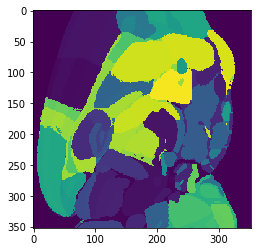

In [58]:
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(im,vmin=0,vmax=255)

## Try Canny edge detection

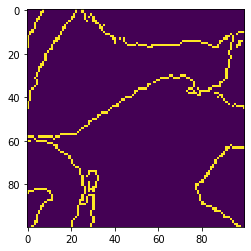

In [212]:
# edge detect
edges = cv2.Canny(im,0,150)
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(edges[100:200,100:200])

In [ ]:
# Not very smooth. Let's try zooming and then edge detecting again

In [213]:
zoomed_im = ndimage.zoom(im, 3.0)

In [214]:
zoomed_im.shape

(1056, 1056)

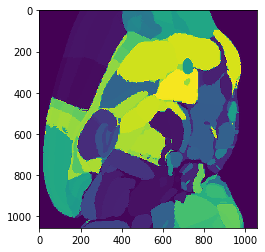

In [215]:
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(zoomed_im,vmin=0,vmax=255)

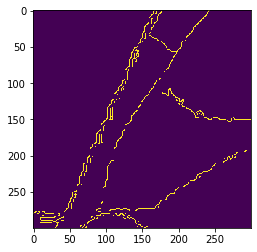

In [216]:
# edge detect
zoomed_edges = cv2.Canny(zoomed_im,0,150)
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(zoomed_edges[200:500,200:500])

In [217]:
# Looks worse

## Try contours

In [221]:
bin_im = im.copy()
bin_im[bin_im!=11] = 0
bin_im = bin_im.astype('uint8')
# calculate the threshold
ret, thresh = cv2.threshold(bin_im, 1, 1, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#create an empty image for contours
img_contours = np.zeros([352,352,3])
# draw the contours on the empty image
_=cv2.drawContours(img_contours, contours, -1, (0,255,0), 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


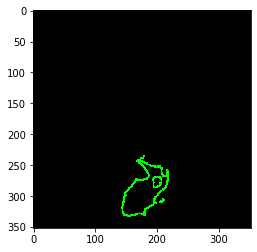

In [222]:
fig = plt.figure()
ax=fig.add_subplot(111)
ax.imshow(img_contours)

Finally got it to work. Thickness 2 looks alright. Would have to loop through and do this for all segments. This made me think to dry the euclidean distance transform since this can act on all segments at once. 

## Seung lab Euclidian Distance Transform

In [224]:
dt_im = edt.edt(
  im, anisotropy=(1,1,1), # keep it in pixel space for now 
  black_border=True, order='F',
  parallel=4 # number of threads, <= 0 sets to num cpu
) 

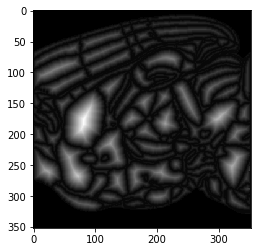

In [225]:
fig = plt.figure()
ax = fig.add_subplot()
# ax.imshow(cv2.drawContours(bin_im, [contours[0]], 0,color=(0,0,0),thickness=5))
ax.imshow(dt_im)

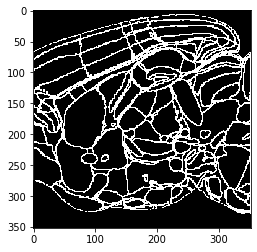

In [226]:
boundary_mask = (dt_im > 0) & (dt_im<2)
fig = plt.figure()
ax = fig.add_subplot()
# ax.imshow(cv2.drawContours(bin_im, [contours[0]], 0,color=(0,0,0),thickness=5))
ax.imshow(boundary_mask)

In [227]:
# Looks good. 

# We can apply this to the whole pma and then save the slices

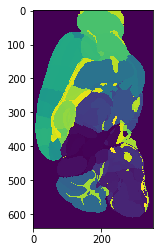

In [152]:
fig = plt.figure()
ax = fig.add_subplot()
# ax.imshow(cv2.drawContours(bin_im, [contours[0]], 0,color=(0,0,0),thickness=5))
ax.imshow(data[200])

In [182]:
# EDT on the 3d data
dt_pma = edt.edt(
  data, anisotropy=(20,20,20), # keep it in pixel space for now 
  black_border=True, order='C',
  parallel=4 # number of threads, <= 0 sets to num cpu
) 

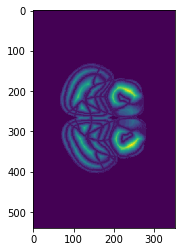

In [184]:
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(dt_pma[:,100,:])

In [185]:
dt_pma.shape

(540, 640, 352)

In [187]:
data[:,:,0].shape

(540, 640)

In [179]:
output_vol = np.zeros_like(data)
for ii in range(len(data)):
    s = data[ii]
    dt_s = edt.edt(
      s, anisotropy=(1,1), # keep it in pixel space for now 
      black_border=True, order='C',
      parallel=4 # number of threads, <= 0 sets to num cpu
    )
    boundary_mask = boundary_mask = (dt_s > 0) & (dt_s<3)
    output_vol[ii] = boundary_mask

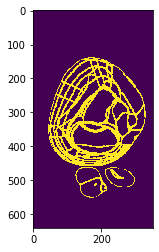

In [180]:
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(output_vol[100])

In [181]:
# Save this file and then make a segmentation volume from it
import tifffile
tifffile.imsave('/home/ahoag/ngdemo/data/princeton_mouse_atlas/pma_boundaries_width2.tif',output_vol)

In [191]:
# Make a simple segment properties file
segment_props_dict = {"@type": "neuroglancer_segment_properties",
    "inline": {"ids": ["1"],
               "properties":[{"id": "label", "type": "label", "values":
                              ['boundaries']}]}}
filename = '/home/ahoag/ngdemo/demo_bucket/atlas/princetonmouse_boundaries_width2/segment_properties/info'
with open(filename,'w') as outfile:
    json.dump(segment_props_dict,outfile,indent=2)

### EDT on the Paxinos atlas

In [192]:
# Actually want it coronally, for paxinos atlas. So let's download that first 
kimvol = CloudVolume('file:///home/ahoag/ngdemo/demo_bucket/atlas/kimatlas/',parallel=True)

In [193]:
kimdata = np.transpose(kimvol[:][...,0],(2,1,0))

Downloading: 100%|██████████| 95/95 [00:00<00:00, 44.75it/s]]













In [194]:
kimdata.shape

(1140, 123, 800)

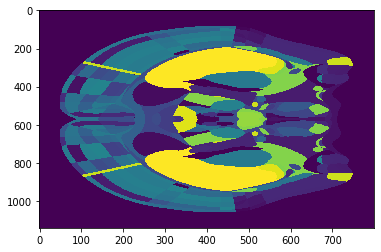

In [200]:
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(kimdata[:,50,:],aspect='auto')

In [201]:
kimdata[:,0,:].shape

(1140, 800)

In [231]:
kimoutput_vol = np.zeros_like(kimdata)
for ii in range(kimdata.shape[1]):
    print(ii)
    s = kimdata[:,ii,:]
    dt_s = edt.edt(
      s, anisotropy=(1,1), # keep it in pixel space for now 
      black_border=True, order='C',
      parallel=4 # number of threads, <= 0 sets to num cpu
    )
    boundary_mask = (dt_s > 0) & (dt_s<3)
    kimoutput_vol[:,ii,:] = boundary_mask

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122


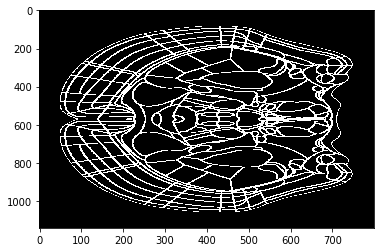

In [232]:
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(kimoutput_vol[:,50,:],aspect='auto')

In [ ]:
# Looks awesome, let's save it
tifffile.imsave('/home/ahoag/ngdemo/data/Chon_et_al/kimatlas_boundaries_width2.tif',kimoutput_vol)


In [228]:
# Let's save the thickness 1 as well to compare.
kimoutput_vol_thick1 = np.zeros_like(kimdata)
for ii in range(kimdata.shape[1]):
    print(ii)
    s = kimdata[:,ii,:]
    dt_s = edt.edt(
      s, anisotropy=(1,1), # keep it in pixel space for now 
      black_border=True, order='C',
      parallel=4 # number of threads, <= 0 sets to num cpu
    )
    boundary_mask = (dt_s > 0) & (dt_s<2)
    kimoutput_vol_thick1[:,ii,:] = boundary_mask

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122


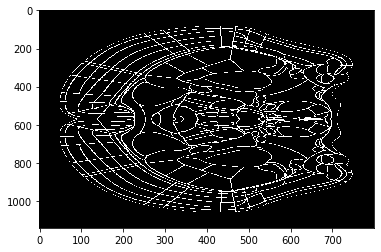

In [229]:
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(kimoutput_vol_thick1[:,50,:],aspect='auto')

In [230]:
# Hard to tell, but let's save and then see what it looks like in Neuroglancer
# Looks awesome, let's save it
tifffile.imsave('/home/ahoag/ngdemo/data/Chon_et_al/kimatlas_boundaries_width1.tif',kimoutput_vol)

In [235]:
False in (kimoutput_vol[:,50,:] == kimoutput_vol_thick1[:,50,:])

True

In [236]:
# Let's save the thickness 1 as well to compare.
kimoutput_vol_thick2 = np.zeros_like(kimdata)
for ii in range(kimdata.shape[1]):
    print(ii)
    s = kimdata[:,ii,:]
    dt_s = edt.edt(
      s, anisotropy=(1,1), # keep it in pixel space for now 
      black_border=True, order='C',
      parallel=4 # number of threads, <= 0 sets to num cpu
    )
    boundary_mask = (dt_s > 0) & (dt_s<3)
    kimoutput_vol_thick2[:,ii,:] = boundary_mask

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122


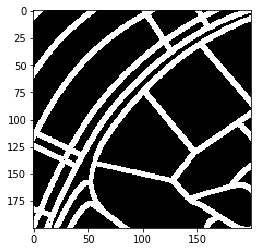

In [246]:
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(kimoutput_vol_thick2[200:400,50,200:400])

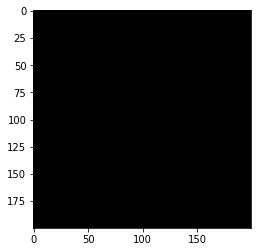

In [251]:
# Gaussian filter
piece = np.array(kimoutput_vol_thick2[200:400,50,200:400])
test = ndimage.gaussian_filter(piece,sigma=1)
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(test)

In [249]:
piece.shape

(200, 200)

In [252]:
test[test!=0]

array([], dtype=uint16)

In [248]:
piece[piece!=0]

VolumeCutout([1, 1, 1, ..., 1, 1, 1], dtype=uint16)

In [253]:
import cv2

kernel = np.ones((5,5),np.float32)/25
dst = cv2.filter2D(piece,-1,kernel)

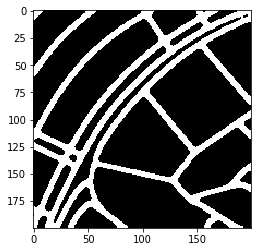

In [254]:
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(dst)